Практическое занятие №6 и Лабораторная работа №4
Изучение методов защиты от атак на модели НС
Защитная дистилляция
Исаев А.М. ББМО-02-22

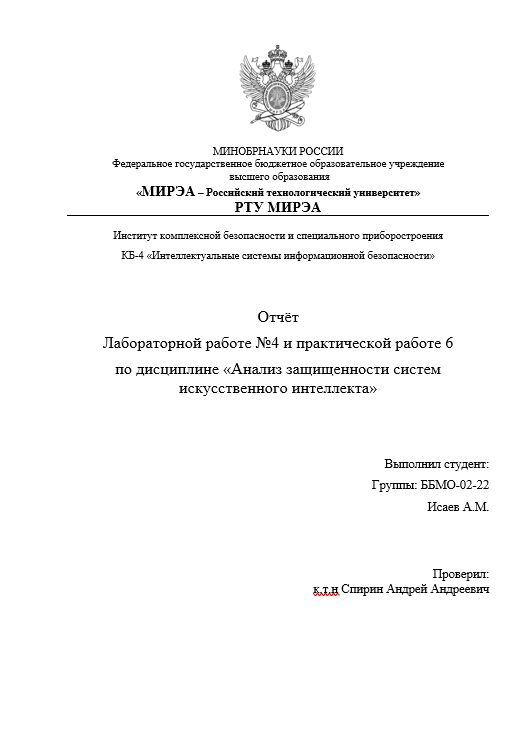![image.png]()

In [ ]:
#импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets


In [ ]:
#Задать нормализующие преобразования, загружаем набор данных (MNIST), разбиваем данные на подвыборки

transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

print("Training data:", len(train_loader), "Validation data:", len(val_loader), "Test data:", len(test_loader))



100%|██████████| 9912422/9912422 [00:00<00:00, 105835317.83it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 115919324.23it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 43929108.87it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24967927.61it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training data: 50000 Validation data: 10000 Test data: 10000


In [ ]:
#Настроить использование графического ускорителя
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

**Создание атак на модель НС**

In [ ]:
#Создаем класс НС на основе фреймворка torch
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [ ]:
# Проверим работоспособность созданного класса НС
model = Net().to(device)

In [ ]:
# Создаем оптимизатор, функцию потерь и трейнер сети
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
factor=0.1, patience=3)

In [ ]:
#Определяем функцию обучения сети
def fit(model, device, train_loader, val_loader, epochs):
    # Создание словаря с загрузчиками данных для тренировки и валидации
    data_loader = {'train': train_loader, 'val': val_loader}
    print("Обучение модели...")

    # Списки для сохранения потерь на тренировочной и валидационной выборках
    train_loss, val_loss = [], []

    # Цикл по эпохам обучения
    for epoch in range(epochs):
        loss_per_epoch, val_loss_per_epoch = 0, 0

        # Цикл по фазам: тренировка и валидация
        for phase in ('train', 'val'):
            for i, data in enumerate(data_loader[phase]):
                # Получение данных и меток, перенос их на устройство (GPU, CPU)
                input, label = data[0].to(device), data[1].to(device)

                # Подача входных данных в модель для получения выхода
                output = model(input)

                # Вычисление функции потерь (Loss) для полученного вывода модели
                loss = criterion(output, label)

                # Обратное распространение ошибки и обновление весов только в фазе тренировки
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    loss_per_epoch += loss.item()
                else:
                    val_loss_per_epoch += loss.item()

            # Если фаза - валидация, то scheduler осуществляется на основе средней величины потерь
            if phase == 'val':
                scheduler.step(val_loss_per_epoch / len(val_loader))

        # Вывод потерь для каждой эпохи и добавление их в списки
        print("Эпоха: {} Потери: {} Валидационные потери: {}".format(epoch + 1, loss_per_epoch / len(train_loader),
                                                                     val_loss_per_epoch / len(val_loader)))
        train_loss.append(loss_per_epoch / len(train_loader))
        val_loss.append(val_loss_per_epoch / len(val_loader))

    # Возврат списков с потерями на тренировочной и валидационной выборках
    return train_loss, val_loss


In [ ]:
# Обучим модель
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Обучение модели...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Эпоха: 1 Потери: 0.255610283002136 Валидационные потери: 0.1248393579045225
Эпоха: 2 Потери: 0.09895044740785226 Валидационные потери: 0.09719064755400392
Эпоха: 3 Потери: 0.07868487370947504 Валидационные потери: 0.08630018315790419
Эпоха: 4 Потери: 0.06849601185211691 Валидационные потери: 0.07462189706799423
Эпоха: 5 Потери: 0.06345447596499887 Валидационные потери: 0.08554755192405492
Эпоха: 6 Потери: 0.057457287483857644 Валидационные потери: 0.07166263678611355
Эпоха: 7 Потери: 0.05495481437340302 Валидационные потери: 0.07101635623094381
Эпоха: 8 Потери: 0.052646400246230025 Валидационные потери: 0.06911218679642703
Эпоха: 9 Потери: 0.049688430059719665 Валидационные потери: 0.08077836483566309
Эпоха: 10 Потери: 0.05279908880530549 Валидационные потери: 0.07761914430055021


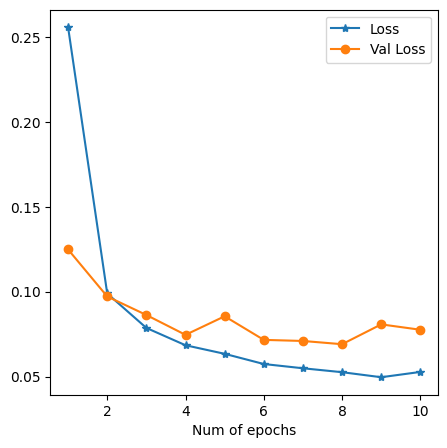

In [ ]:
# Построим графики потерь при обучении и валидации в зависимости от эпохи
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [ ]:
# Создадим функции атак FGSM, I-FGSM, MI-FGSM
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out


In [ ]:
# Создадим функцию проверки
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples

Epsilon: 0	Test Accuracy = 9703 / 10000 = 0.9703
Epsilon: 0.007	Test Accuracy = 9684 / 10000 = 0.9684
Epsilon: 0.01	Test Accuracy = 9641 / 10000 = 0.9641
Epsilon: 0.02	Test Accuracy = 9605 / 10000 = 0.9605
Epsilon: 0.03	Test Accuracy = 9506 / 10000 = 0.9506
Epsilon: 0.05	Test Accuracy = 9265 / 10000 = 0.9265
Epsilon: 0.1	Test Accuracy = 8186 / 10000 = 0.8186
Epsilon: 0.2	Test Accuracy = 4357 / 10000 = 0.4357
Epsilon: 0.3	Test Accuracy = 1610 / 10000 = 0.161


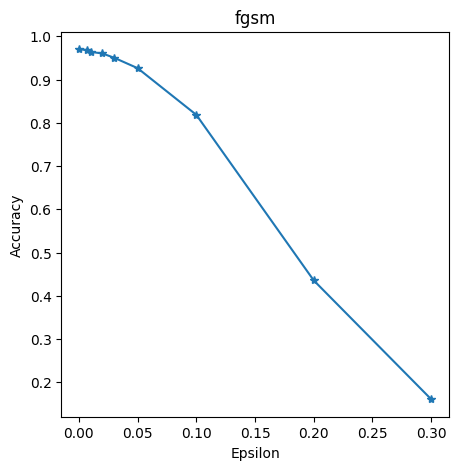

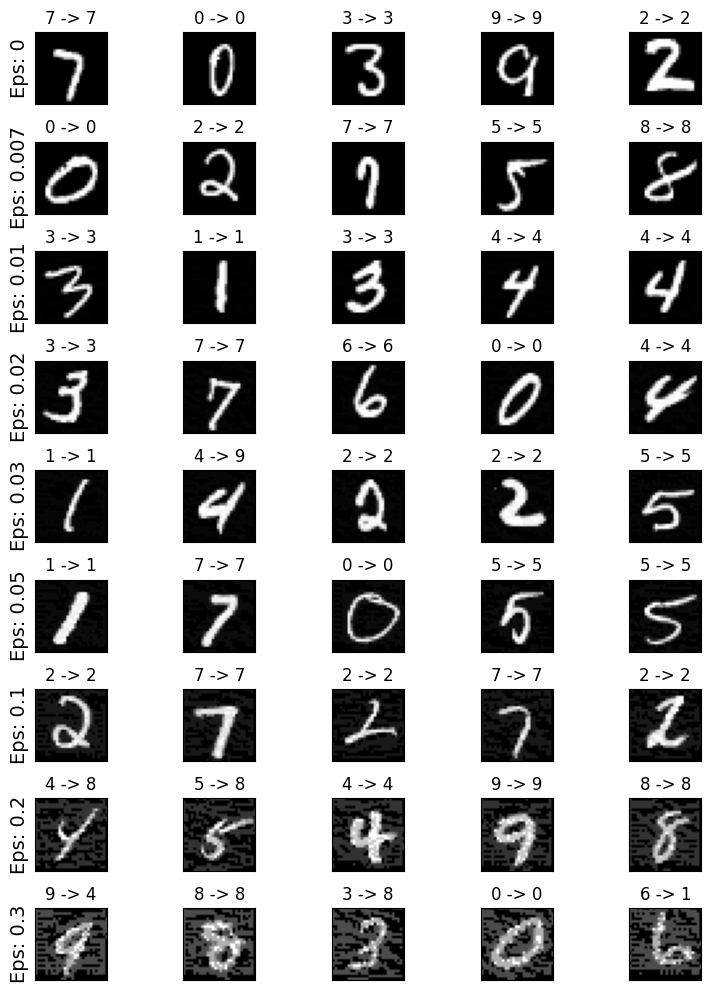

Epsilon: 0	Test Accuracy = 9706 / 10000 = 0.9706
Epsilon: 0.007	Test Accuracy = 9683 / 10000 = 0.9683
Epsilon: 0.01	Test Accuracy = 9670 / 10000 = 0.967
Epsilon: 0.02	Test Accuracy = 9621 / 10000 = 0.9621
Epsilon: 0.03	Test Accuracy = 9545 / 10000 = 0.9545
Epsilon: 0.05	Test Accuracy = 9346 / 10000 = 0.9346
Epsilon: 0.1	Test Accuracy = 8489 / 10000 = 0.8489
Epsilon: 0.2	Test Accuracy = 5128 / 10000 = 0.5128
Epsilon: 0.3	Test Accuracy = 2158 / 10000 = 0.2158


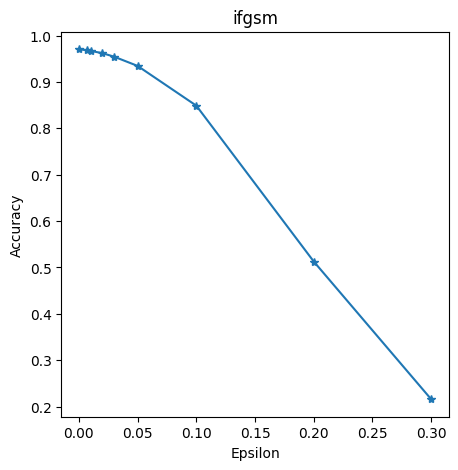

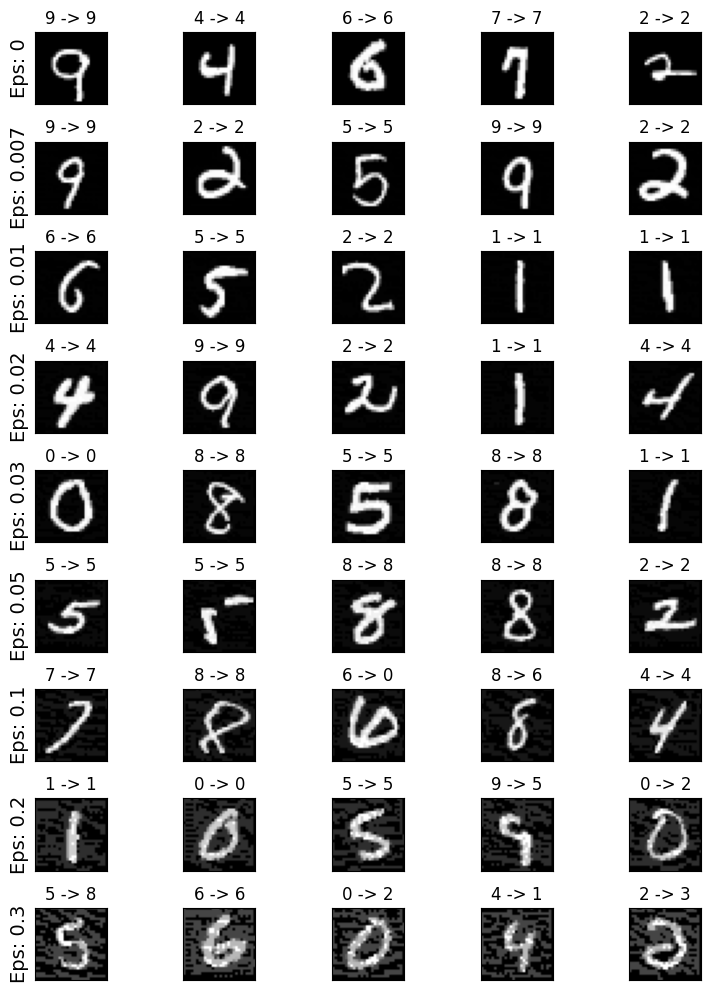

Epsilon: 0	Test Accuracy = 9705 / 10000 = 0.9705
Epsilon: 0.007	Test Accuracy = 9680 / 10000 = 0.968
Epsilon: 0.01	Test Accuracy = 9682 / 10000 = 0.9682
Epsilon: 0.02	Test Accuracy = 9597 / 10000 = 0.9597
Epsilon: 0.03	Test Accuracy = 9525 / 10000 = 0.9525
Epsilon: 0.05	Test Accuracy = 9359 / 10000 = 0.9359
Epsilon: 0.1	Test Accuracy = 8452 / 10000 = 0.8452
Epsilon: 0.2	Test Accuracy = 5143 / 10000 = 0.5143
Epsilon: 0.3	Test Accuracy = 2191 / 10000 = 0.2191


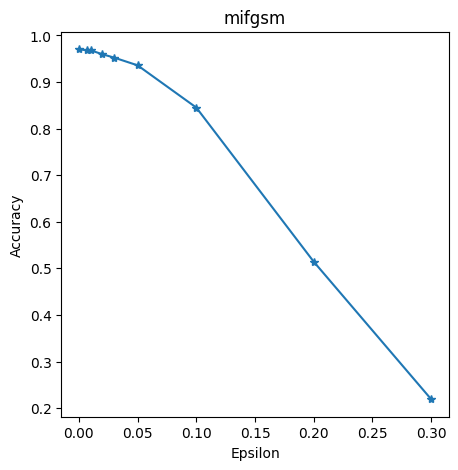

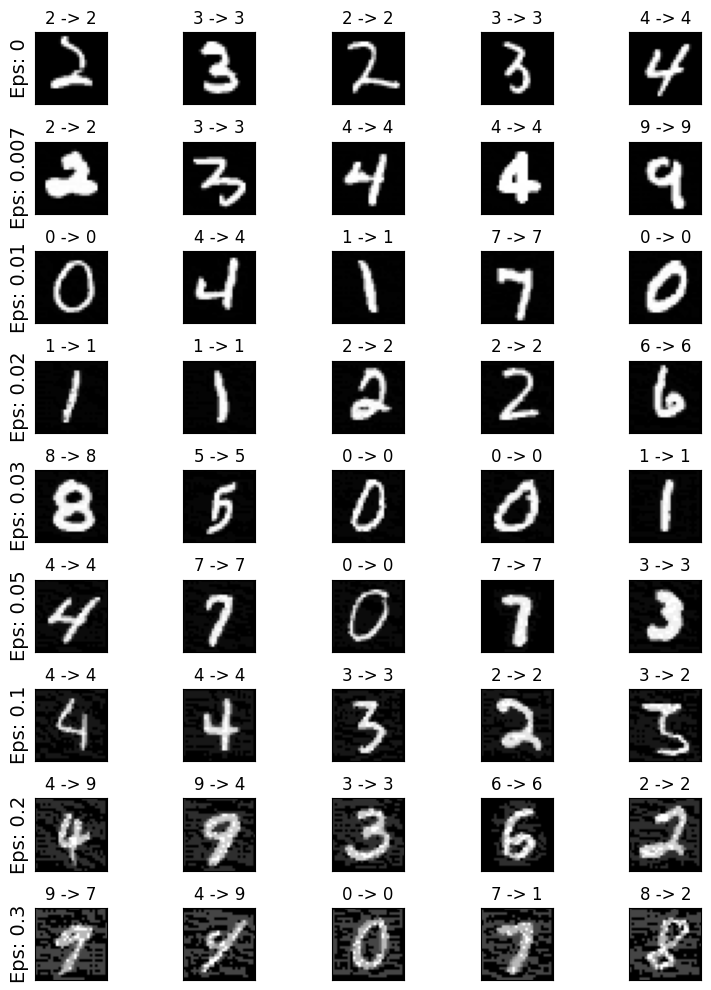

In [ ]:
# Построим графики успешности атак (Accuracy/epsilon) и примеры выполненных атак в зависимости от степени eps
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

**Защита от атак**

In [ ]:
# Создадим 2 класса НС
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [ ]:
# Переопределим функцию обучения и тестирования
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

In [ ]:
# Создадим функцию защиты методом дистилляции
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()
    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
      for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
          plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

Получим результаты оценки защищенных сетей

Fitting the model...
Epoch: 1 Loss: 0.5391946380937632 Val_Loss: 9.28345350548625e-06
Epoch: 2 Loss: 0.3462265867463714 Val_Loss: 1.4836893230676651e-05
Epoch: 3 Loss: 0.27470907573587783 Val_Loss: 6.56339482520707e-07
Epoch: 4 Loss: 0.20992892084899967 Val_Loss: 2.5519561813780457e-08
Epoch: 5 Loss: 0.16466535793793027 Val_Loss: 1.7413168934581336e-06
Epoch: 6 Loss: 0.13530578621705497 Val_Loss: 1.8989071395481005e-08
Epoch: 7 Loss: 0.11893993278364547 Val_Loss: 3.532048547640443e-07
Epoch: 8 Loss: 0.10638665631141539 Val_Loss: 6.675703389191767e-10
Epoch: 9 Loss: 0.09553353692651466 Val_Loss: 5.00813830876723e-07
Epoch: 10 Loss: 0.0953567558376577 Val_Loss: 8.117316289713017e-07


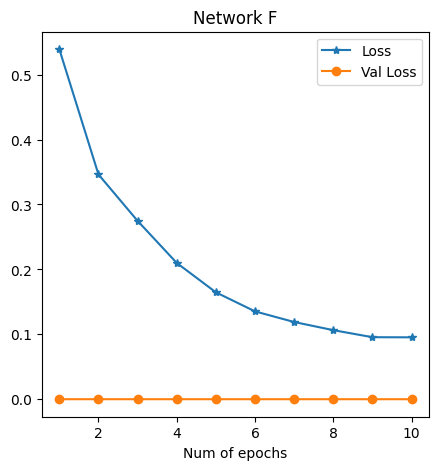

Fitting the model...
Epoch: 1 Loss: 0.6751219428886607 Val_Loss: 7.080280687659978e-07
Epoch: 2 Loss: 0.43689828398372055 Val_Loss: 7.4385233223438265e-06
Epoch: 3 Loss: 0.3643022284169988 Val_Loss: 3.3464681124314667e-06
Epoch: 4 Loss: 0.3017165302704768 Val_Loss: 3.172991200699471e-08
Epoch: 5 Loss: 0.258322810764531 Val_Loss: 1.4149636263027787e-08
Epoch: 6 Loss: 0.2316158757881164 Val_Loss: 1.0666514745935275e-06
Epoch: 7 Loss: 0.20787243991750085 Val_Loss: 6.166153587400913e-06
Epoch: 8 Loss: 0.19216428940365649 Val_Loss: 8.612787276506424e-05
Epoch: 9 Loss: 0.17598913601397256 Val_Loss: 3.3517192787257955e-08
Epoch: 10 Loss: 0.16190739567294757 Val_Loss: 5.514107295311987e-07


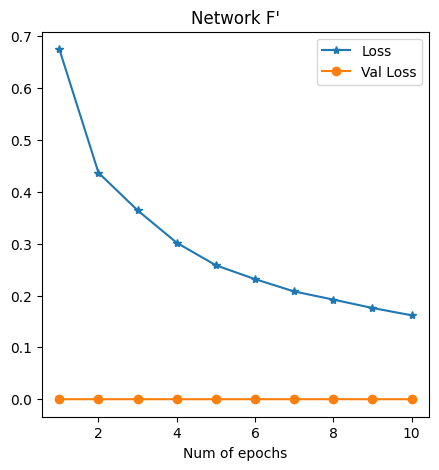

Epsilon: 0	Test Accuracy = 9280 / 10000 = 0.928
Epsilon: 0.007	Test Accuracy = 9196 / 10000 = 0.9196
Epsilon: 0.01	Test Accuracy = 9187 / 10000 = 0.9187
Epsilon: 0.02	Test Accuracy = 9092 / 10000 = 0.9092
Epsilon: 0.03	Test Accuracy = 8889 / 10000 = 0.8889
Epsilon: 0.05	Test Accuracy = 8470 / 10000 = 0.847
Epsilon: 0.1	Test Accuracy = 6980 / 10000 = 0.698
Epsilon: 0.2	Test Accuracy = 2794 / 10000 = 0.2794
Epsilon: 0.3	Test Accuracy = 711 / 10000 = 0.0711


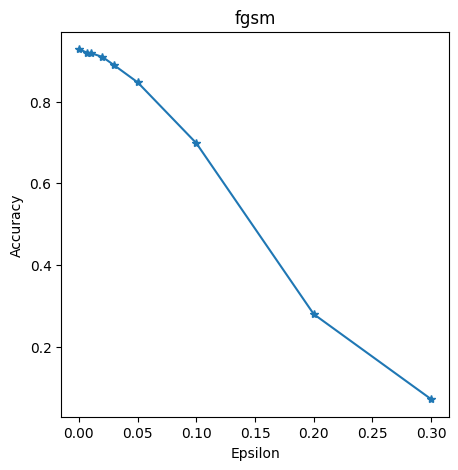

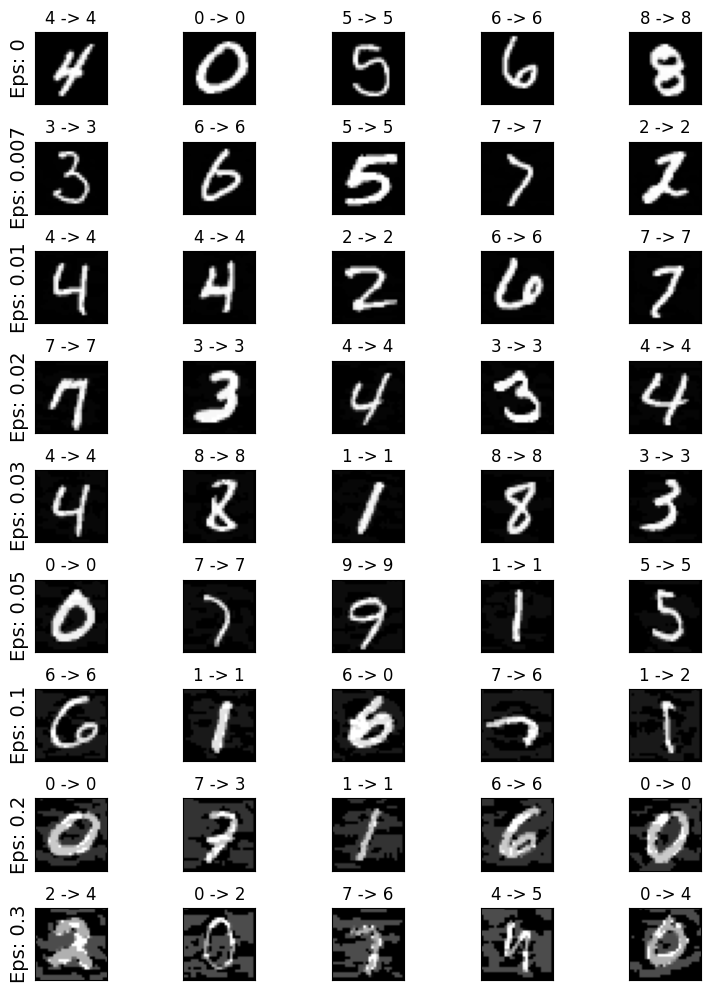

Epsilon: 0	Test Accuracy = 9273 / 10000 = 0.9273
Epsilon: 0.007	Test Accuracy = 9204 / 10000 = 0.9204
Epsilon: 0.01	Test Accuracy = 9183 / 10000 = 0.9183
Epsilon: 0.02	Test Accuracy = 9112 / 10000 = 0.9112
Epsilon: 0.03	Test Accuracy = 8929 / 10000 = 0.8929
Epsilon: 0.05	Test Accuracy = 8585 / 10000 = 0.8585
Epsilon: 0.1	Test Accuracy = 7398 / 10000 = 0.7398
Epsilon: 0.2	Test Accuracy = 3591 / 10000 = 0.3591
Epsilon: 0.3	Test Accuracy = 1095 / 10000 = 0.1095


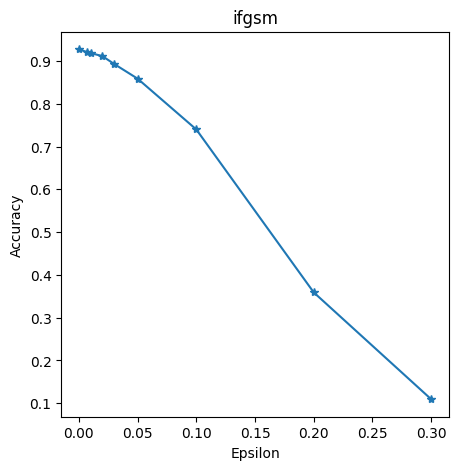

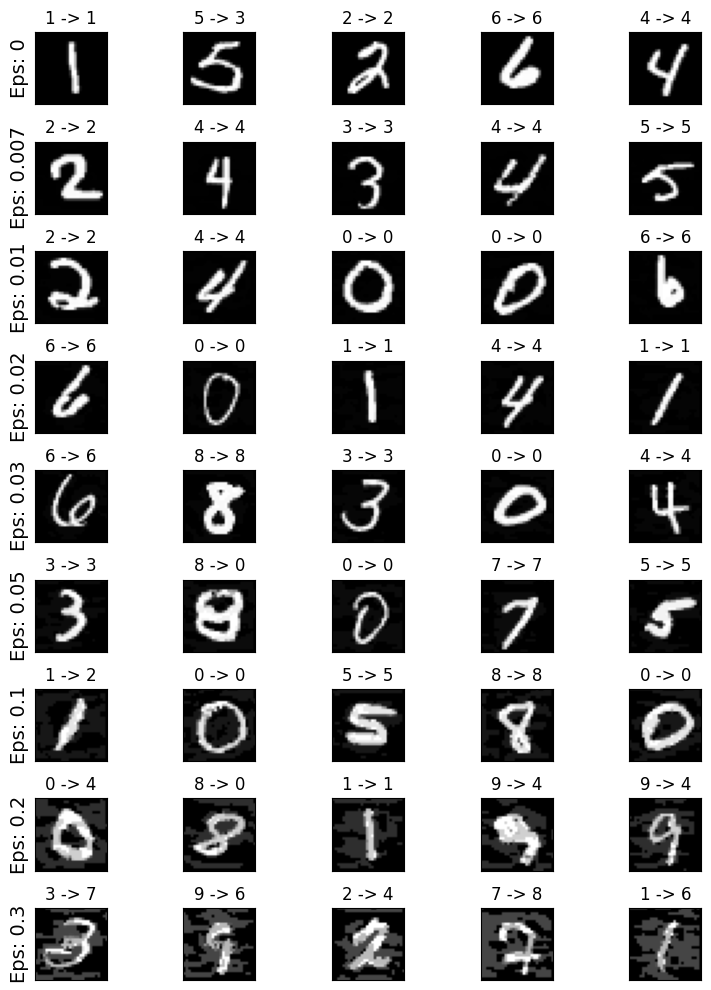

Epsilon: 0	Test Accuracy = 9273 / 10000 = 0.9273
Epsilon: 0.007	Test Accuracy = 9217 / 10000 = 0.9217
Epsilon: 0.01	Test Accuracy = 9228 / 10000 = 0.9228
Epsilon: 0.02	Test Accuracy = 9063 / 10000 = 0.9063
Epsilon: 0.03	Test Accuracy = 8933 / 10000 = 0.8933
Epsilon: 0.05	Test Accuracy = 8564 / 10000 = 0.8564
Epsilon: 0.1	Test Accuracy = 7385 / 10000 = 0.7385
Epsilon: 0.2	Test Accuracy = 3599 / 10000 = 0.3599
Epsilon: 0.3	Test Accuracy = 1161 / 10000 = 0.1161


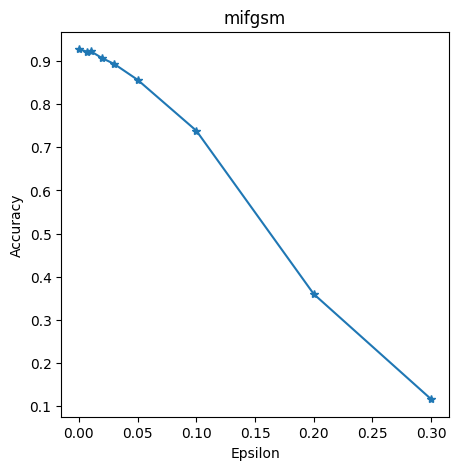

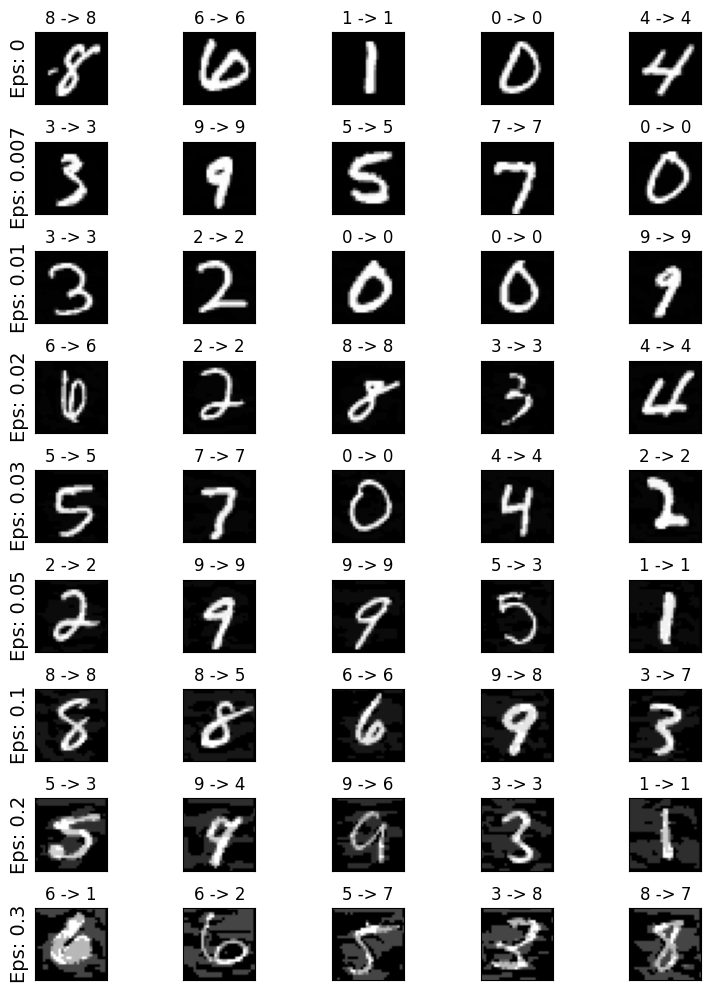

In [ ]:
# Получаем результаты оценки защищенных сетей
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)